# Testing Double Descent

References:

Belkin, et al. (PNAS, 2019)
"Reconciling modern machine-learning practice and the classical bias–variance trade-off"

In [574]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [349]:
# set layer_list to be a list of the number of nodes in a given layer

class Net(nn.Module):

    def __init__(self, layer_list):
        super().__init__()
        prev = 28 * 28 # MNIST dimension
        self.llen = len(layer_list)
        self.fc = [0 for i in range(self.llen)]
        for i in range(self.llen):
            fc_num = layer_list[i]
            exec(f"self.fc{i} = nn.Linear(prev, fc_num)")
            exec(f"self.fc[i] = self.fc{i}")
            prev  = fc_num
    
        # ReLU
        self.relu = nn.ReLU()

        # last layer    
        self.final_layer = nn.Linear(prev, 10)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = x.view((x.shape[0], -1))

        x = self.fc0(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)

        # for i in range(self.llen):
        #     x = self.fc[i](x) # Linear
        #     x = self.relu(x) # ReLU
        
        x = self.final_layer(x)
        output = self.log_softmax(x)
        
        return output

In [350]:
model

Net(
  (fc0): Linear(in_features=784, out_features=1000, bias=True)
  (fc1): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (relu): ReLU()
  (final_layer): Linear(in_features=1000, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=-1)
)

In [351]:
# testing nn

layer_list = [1000,1000,1000]
model = Net(layer_list)

input_ = torch.rand(1,28,28)
out = model(input_)

print(f"size: {out.shape}")
print(f"max arg: {torch.argmax(out)}")


size: torch.Size([1, 10])
max arg: 4


## Train Neural Network

In [402]:
# Set layers
layer_list = [1000,1000,1000,1000]
model = Net(layer_list)

In [403]:
# Import datasets

# training set
dataset_mnist_train = datasets.MNIST('./data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))]) # MNIST parameters
) 

# test set
dataset_mnist_test = datasets.MNIST('./data', 
    train=False, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))]) # MNIST parameters
) 


train_loader = data_utils.DataLoader(dataset_mnist_train,
    batch_size=128,
    shuffle=True)

test_loader = data_utils.DataLoader(dataset_mnist_test,
    batch_size=128,
    shuffle=False)

In [404]:
parameters_to_optimize = model.parameters()

# stochastic gradient descent
optimizer = opt.SGD(model.parameters(), lr=0.1, momentum=0.9)

# log-likelihood loss
loss_fn = nn.NLLLoss()

In [415]:
def train(model, loss_fn, device, train_loader, test_loader, optimizer):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(torch.argmax(output, 1))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'[{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item()}')
            test(model, loss_fn, device, test_loader)

def test(model, loss_fn, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'\nTest set Accuracy: {correct}/{len(test_loader.dataset)} ({100.*correct/len(test_loader.dataset):.1f}%)\n')


In [416]:
train(model, loss_fn, 'cpu', train_loader, test_loader, optimizer)

[0/60000]	Loss: 2.304487466812134

Test set Accuracy: 1251/10000 (12.5%)

[3840/60000]	Loss: 0.2785820960998535

Test set Accuracy: 8800/10000 (88.0%)

[7680/60000]	Loss: 0.31419241428375244

Test set Accuracy: 9115/10000 (91.2%)

[11520/60000]	Loss: 0.2975822389125824

Test set Accuracy: 9049/10000 (90.5%)

[15360/60000]	Loss: 0.2230495810508728

Test set Accuracy: 9237/10000 (92.4%)

[19200/60000]	Loss: 0.14582450687885284


KeyboardInterrupt: 

In [408]:
test(model, loss_fn, "cpu", test_loader)


Test set Accuracy: 842/10000 (8.4%)



0.9158

## Change parameters to see Double Descent

 Number of training data parameters: 
 $60{,}000 \times 28 \times 28 = 47{,}040{,}000$

 -> We should see peak around that point
  $5\times10^{7}\simeq 3000*3000*6$ 

  (Exact number for $6$ hidden layers is $893.8$ per layer)

In [426]:
# refine functions for multiple training

def train(model, loss_fn, device, train_loader, test_loader, optimizer):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(torch.argmax(output, 1))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

def test(model, loss_fn, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Test set Accuracy: {correct}/{len(test_loader.dataset)} ({100.*correct/len(test_loader.dataset):.1f}%)')

    # Error rate -> use to draw graph
    return 1 - correct/len(test_loader.dataset)

In [558]:
# initialize
layer_list = np.array([25,25,25,25,25,25])
results = []

for i in range(500):
    layer_list = np.array(layer_list + 10, dtype=int) 
    model = Net(layer_list)
    parameters_to_optimize = model.parameters()
    optimizer = opt.SGD(model.parameters(), lr=0.1, momentum=0.9)

    train(model, loss_fn,'cpu',train_loader,test_loader,optimizer)
    results.append(test(model, loss_fn, "cpu", test_loader))

Test set Accuracy: 9402/10000 (94.0%)
Test set Accuracy: 9397/10000 (94.0%)
Test set Accuracy: 9495/10000 (95.0%)
Test set Accuracy: 9491/10000 (94.9%)
Test set Accuracy: 9547/10000 (95.5%)
Test set Accuracy: 9453/10000 (94.5%)
Test set Accuracy: 9519/10000 (95.2%)
Test set Accuracy: 9629/10000 (96.3%)
Test set Accuracy: 9608/10000 (96.1%)
Test set Accuracy: 9564/10000 (95.6%)
Test set Accuracy: 9547/10000 (95.5%)
Test set Accuracy: 9620/10000 (96.2%)
Test set Accuracy: 9635/10000 (96.3%)
Test set Accuracy: 9565/10000 (95.7%)
Test set Accuracy: 9628/10000 (96.3%)
Test set Accuracy: 9548/10000 (95.5%)
Test set Accuracy: 9607/10000 (96.1%)
Test set Accuracy: 9522/10000 (95.2%)
Test set Accuracy: 9576/10000 (95.8%)
Test set Accuracy: 9629/10000 (96.3%)
Test set Accuracy: 9589/10000 (95.9%)
Test set Accuracy: 9597/10000 (96.0%)
Test set Accuracy: 9652/10000 (96.5%)
Test set Accuracy: 9629/10000 (96.3%)
Test set Accuracy: 9667/10000 (96.7%)
Test set Accuracy: 9667/10000 (96.7%)
Test set Acc

In [559]:
results8 = results

In [560]:
layer_list8 = []
init = 25
for i in range(500):
    init += 10 
    layer_list8.append(init)

In [546]:
layer_list7

[30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580,
 1590,
 1600

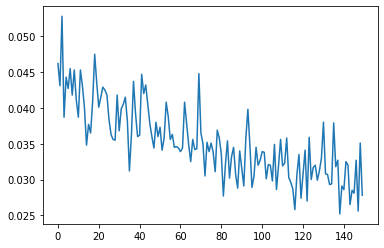

In [536]:
plt.plot(results6)

plt.show()

In [537]:
import scipy
from scipy.optimize import curve_fit

def expo(x, a, b):
    return a * scipy.exp(-x) +b

In [564]:
layer_list11 = layer_list1[:23]
results11 = results1[:23]

hidden_n = layer_list11 + layer_list2 + layer_list3 + layer_list4 + layer_list5 + layer_list6 + layer_list7 + layer_list8
error_rate = results11 + results2 + results3 + results4 + results5 + results6 + results7 + results8

hidden_n, error_rate = zip(*sorted(zip(hidden_n, error_rate)))

In [548]:
param, _ = curve_fit(expo, layer_list7, results7)

In [555]:
fit_x = np.linspace(300,5000,100)
fit_y = expo(fit_x, *param)

In [540]:
def param_n(hidden):
    return 5 * hidden ** 2 + 794 * hidden

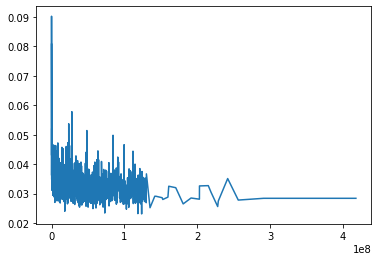

In [579]:
plt.plot(param_n(np.array(hidden_n)), error_rate)
# plt.plot(fit_x, fit_y)
# xlim(100, 120000000)
plt.show()

In [583]:
import pickle

file_name1 = "layers.txt"
file_name2 = "results.txt"

open_file = open(file_name1, "wb")
pickle.dump(hidden_n, open_file)
open_file.close()

open_file = open(file_name2, "wb")
pickle.dump(error_rate, open_file)
open_file.close()


In [576]:
from matplotlib.pyplot import xlim

In [497]:
layer_list

array([4139, 4139, 4139, 4139, 4139, 4139])

In [567]:
print(max(layer_list11))
print(max(layer_list2))
print(max(layer_list3))
print(max(layer_list4))
print(max(layer_list5))
print(max(layer_list6))
print(max(layer_list7))
print(max(layer_list8))

6537
6688
9062
4139
3574
7081
5020
5025


In [578]:
xlim

(200, 8000)